In [891]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [892]:
df = pd.read_csv('../data/raw/clinical_data_lung.zip')

In [893]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [894]:
df.columns

Index(['Age recode with <1 year olds and 90+',
       'Race recode (White, Black, Other)', 'Primary Site - labeled',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural-Urban Continuum Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Tota

# Analisis de variables

# 1. Variables Demográficas y Socioeconómicas

## Eliminacion de columnas que no son de valor significativo

In [895]:
columns_to_drop = ["Type of Reporting Source", 
                   "Grade Clinical (2018+)",
                   "Sequence number",
                   "Primary Site"]
#df = df.drop(columns=columns_to_drop)

#### Observaciones:
> - `Race and origin (recommended by SEER)` se elimina debido a que es una etiqueta general.
> - `Type of Reporting Source` se elimina debido a la dominancia excesiva de (Hospital inpatient/outpatient or clinic) y categorías minoritarias como (Autopsy only) con apenas 454 registros.
> - `Diagnostic Confirmation`  una vez limpio el conjunto de datos de estos registros no validados por diagnósticos se elimina la columna.
> - `Origin recode NHIA (Hispanic, Non-Hisp)`  Esa informacion solo contiene 2 tipos de caracteristicas prenominando una de ellas con mas del 90% de los datos
> - `PRCDA 2020` Indirectamente, PRCDA suele estar asociada a zonas más rurales o comunidades específicas, Esta variable está fuertemente ligada a la raza (American Indian/Alaska Native), al tener una variable que ya nos clasifica las razas esta no es necesaria
> - `Primary Site` existe otra variable que tambien refleja donde comenzo a crecer el tumor  

In [896]:
df.columns

Index(['Age recode with <1 year olds and 90+',
       'Race recode (White, Black, Other)', 'Primary Site - labeled',
       'Histologic Type ICD-O-3', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Derived EOD 2018 Stage Group Recode (2018+)',
       '7th Edition Stage Group Recode (2016-2017)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Median household income inflation adj to 2023',
       'RX Summ--Surg Prim Site (1998+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural-Urban Continuum Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Tota

## Age 

In [897]:
df.groupby("Age recode with <1 year olds and 90+")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Age recode with <1 year olds and 90+,,
00 years,19,1
01-04 years,32,5
05-09 years,14,3
10-14 years,28,7
15-19 years,68,17
20-24 years,141,55
25-29 years,246,129
30-34 years,436,318
35-39 years,764,768


se puede observar que las edades estan divididas en en rango de edades de 5 años aproximadamente, se procedera a reagrupar a las personas en grupos mas grandes siguiendo una lógica fisiológica y clínica.
 
Grupo 1 (0-19 años): Pediátrico/Adolescente. Cánceres con biología muy distinta y alta tasa de supervivencia en muchos casos.

Grupo 2 (20-39 años): Adulto Joven. Pacientes con pocas comorbilidades (otras enfermedades) pero donde el cáncer puede ser más agresivo.

Grupo 3 (40-59 años): Adulto Medio. La etapa donde aumenta la incidencia; es el "estándar" del dataset.

Grupo 4 (60-75 años): Adulto Mayor. Comienzan a aparecer otros problemas de salud que afectan el tratamiento.

Grupo 5 (>75 años): Gerátrico. El riesgo de mortalidad no relacionada con el cáncer es muy alto y los tratamientos suelen ser menos invasivos.

In [898]:
# agregar una columna de grupo de edades 

# 1. Definimos los rangos para cada grupo
grupo_1 = ['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years']
grupo_2 = ['20-24 years', '25-29 years', '30-34 years', '35-39 years']
grupo_3 = ['40-44 years','45-49 years', '50-54 years', '55-59 years']
grupo_4 =['60-64 years','65-69 years', '70-74 years']
# El resto (65+) caerá en el grupo 5

# 2. Función lógica para asignar el grupo
def asignar_grupo(edad):
    if edad in grupo_1: return 1
    if edad in grupo_2: return 2
    if edad in grupo_3: return 3
    if edad in grupo_4: return 4
    return 5  # Todo lo que no esté en los anteriores (80+)

# 3. Creamos la columna
df['age_group'] = df['Age recode with <1 year olds and 90+'].apply(asignar_grupo)

# 4. Verificamos los conteos
df['age_group'].value_counts().sort_index()

age_group
1       194
2      2857
3     79595
4    256857
5    197915
Name: count, dtype: int64

al tener una nueva columna con las edades divididas en grupos no necesitamos la anterior por tal motivo procedemos a eliminarla

In [899]:
# Eliminamos la columna original de edad
df.drop('Age recode with <1 year olds and 90+', axis=1, inplace=True)

## sex

In [900]:
df.groupby("Sex")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Sex,,
Female,83863,179031
Male,64223,210301


## Race recode (White, Black, Other)

In [901]:
# cambiar el nombre de la columna a Race
df.rename(columns={'Race recode (White, Black, Other)': 'Race'}, inplace=True)

df["Race"].value_counts()



Race
White                                                        434822
Black                                                         57145
Other (American Indian/AK Native, Asian/Pacific Islander)     43620
Unknown                                                        1831
Name: count, dtype: int64

Se observan 4 tipos de caracteristicas, agruparemos  las caracteristicas de Other con Unknown en una sola caracteristica "Other"

In [902]:
# Definimos la lista de las categorías que queremos agrupar
a_renombrar = ['Other (American Indian/AK Native, Asian/Pacific Islander)', 'Unknown']

# Reemplazamos esos valores por 'Other'
df['Race'] = df['Race'].replace(a_renombrar, 'Other')

In [903]:
df.groupby("Race")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Race,,
Black,14496,42649
Other,15910,29541
White,117680,317142


## 'Rural-Urban Continuum Code'

In [904]:
df['Rural-Urban Continuum Code'].value_counts().sort_index()

Rural-Urban Continuum Code
Counties in metropolitan areas ge 1 million pop                 291753
Counties in metropolitan areas of 250,000 to 1 million pop      113711
Counties in metropolitan areas of lt 250 thousand pop            46491
Nonmetropolitan counties adjacent to a metropolitan area         49586
Nonmetropolitan counties not adjacent to a metropolitan area     35039
Unknown/missing/no match (Alaska or Hawaii - Entire State)         821
Unknown/missing/no match/Not 1990-2023                              17
Name: count, dtype: int64

In [905]:
df.groupby("Rural-Urban Continuum Code")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Rural-Urban Continuum Code,,
Counties in metropolitan areas ge 1 million pop,86580,205173
"Counties in metropolitan areas of 250,000 to 1 million pop",31083,82628
Counties in metropolitan areas of lt 250 thousand pop,11186,35305
Nonmetropolitan counties adjacent to a metropolitan area,11885,37701
Nonmetropolitan counties not adjacent to a metropolitan area,7174,27865
Unknown/missing/no match (Alaska or Hawaii - Entire State),171,650
Unknown/missing/no match/Not 1990-2023,7,10


podemos observar que las dos clasificaciones desconocidas ademas de tener pocos datos no se consideran muy relevantes el porcentaje de personas vivas al final de  la ultima fecha de estudio por tal motivo procederan a eliminarse y tambien cambiaremos el nombre de la columna a "Rural Code"

In [906]:
df.rename(columns={'Rural-Urban Continuum Code': 'Rural Code'}, inplace=True)

# 1. características a eliminar
a_eliminar = ['Unknown/missing/no match (Alaska or Hawaii - Entire State)', 'Unknown/missing/no match/Not 1990-2023']

# 2. Sobreescribimos el dataframe filtrando: "Manten los que NO estén en la lista"
df = df[~df['Rural Code'].isin(a_eliminar)]

In [907]:
df['Rural Code'].value_counts()

Rural Code
Counties in metropolitan areas ge 1 million pop                 291753
Counties in metropolitan areas of 250,000 to 1 million pop      113711
Nonmetropolitan counties adjacent to a metropolitan area         49586
Counties in metropolitan areas of lt 250 thousand pop            46491
Nonmetropolitan counties not adjacent to a metropolitan area     35039
Name: count, dtype: int64

## Median household income inflation adj to 2023

In [908]:
df[ 'Median household income inflation adj to 2023'].unique()


array(['$120,000+', '$110,000 - $119,999', '$100,000 - $109,999',
       '$95,000 - $99,999', '$90,000 - $94,999', '$85,000 - $89,999',
       '$80,000 - $84,999', '$75,000 - $79,999', '$70,000 - $74,999',
       '$65,000 - $69,999', '$60,000 - $64,999', '$55,000 - $59,999',
       '$50,000 - $54,999', '$45,000 - $49,999', '< $40,000',
       '$40,000 - $44,999'], dtype=object)

Propuesta de Reagrupación Óptima

Dividiremos los ingresos basándonos en la distribución típica de niveles de vida (Bajo, Medio-Bajo, Medio, Medio-Alto, Alto):

Grupo 1: Nivel Bajo (Menos de $45k) Representa a la población con mayores barreras económicas.

Grupo 2: Nivel Medio-Bajo ($45k - $64k)

Grupo 3: Nivel Medio ($65k - $84k)

Grupo 4: Nivel Medio-Alto ($85k - $109k)

Grupo 5: Nivel Alto (Más de $110k)

Incluye: $110,000 - $119,999 y $120,000+.

In [909]:
# Usaremos un diccionario de mapeo para asegurar que cada string se convierta exactamente en el número del grupo.

# Definimos el mapeo manual para asegurar precisión
map_ingresos = {
    '< $40,000': 1, '$40,000 - $44,999': 1,
    '$45,000 - $49,999': 2, '$50,000 - $54,999': 2, '$55,000 - $59,999': 2, '$60,000 - $64,999': 2,
    '$65,000 - $69,999': 3, '$70,000 - $74,999': 3, '$75,000 - $79,999': 3, '$80,000 - $84,999': 3,
    '$85,000 - $89,999': 4, '$90,000 - $94,999': 4, '$95,000 - $99,999': 4, '$100,000 - $109,999': 4,
    '$110,000 - $119,999': 5, '$120,000+': 5
}

# Creamos la nueva columna
df['income_level'] = df['Median household income inflation adj to 2023'].map(map_ingresos)


df.groupby("income_level")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)


Vital status recode (study cutoff used),Alive,Dead
income_level,,
1,3669,17841
2,23520,90097
3,45847,140737
4,50161,100229
5,24711,39768


In [910]:
# Eliminamos la columna original de nivel de ingresos
df.drop('Median household income inflation adj to 2023', axis=1, inplace=True)

# 2. Variables del Tumor (Biología y Localización)

## Primary Site - labeled

In [911]:
df["Primary Site - labeled"].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              263801
C34.3-Lower lobe, lung              140653
C34.9-Lung, NOS                      82876
C34.2-Middle lobe, lung              23164
C34.0-Main bronchus                  20900
C34.8-Overlapping lesion of lung      5186
Name: count, dtype: int64

Indica en qué parte específica del pulmón se originó el tumor.

C34.1, C34.2, C34.3: Lóbulos superior, medio e inferior. Es vital para la supervivencia; los tumores en el lóbulo superior a veces tienen pronósticos distintos por la cercanía a grandes vasos.

C34.0 (Main bronchus): El bronquio principal. Suele ser más central y difícil de operar.

C34.9 (Lung, NOS): "Not Otherwise Specified". Significa que en la historia clínica solo dice "pulmón" sin aclarar el lóbulo.

C34.8 (Overlapping lesion): El tumor es tan grande que abarca más de un lóbulo.

Dado que la clasificacion "C34.9-Lung NOS" no nos devuelve informacion sobre donde se encuentra el tomor se hace dificil tomar decisiones sobre como enfrentar a ese tumor ya que no se sabe la gravedad del mismo, por tal motivo esta clasificación crea ruido para futuras predicciones del modelo.

In [912]:
# 1. Filtramos: Nos quedamos con todas las filas donde el valor NO SEA 'C34.9-Lung, NOS'
df = df[df['Primary Site - labeled'] != 'C34.9-Lung, NOS']

# 2. Reiniciamos los índices para eliminar los huecos de las filas borradas
df = df.reset_index(drop=True)

df['Primary Site - labeled'].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              263801
C34.3-Lower lobe, lung              140653
C34.2-Middle lobe, lung              23164
C34.0-Main bronchus                  20900
C34.8-Overlapping lesion of lung      5186
Name: count, dtype: int64

In [913]:
df.rename(columns={'Primary Site - labeled': 'Primary Site'}, inplace=True)

## Histologic Type ICD-O-3 

In [914]:
df["Histologic Type ICD-O-3"].unique()


array([8140, 8550, 8070, 8000, 8041, 8046, 8240, 8010, 8560, 8246, 8255,
       8551, 8012, 8254, 8252, 8230, 8480, 8073, 8071, 8260, 8250, 8022,
       8072, 8033, 8980, 8430, 8032, 8265, 8249, 8481, 8020, 8253, 8310,
       8043, 8083, 8507, 8800, 8013, 8200, 8244, 9120, 9041, 8323, 8082,
       8490, 8045, 8144, 8802, 8890, 8044, 8574, 8256, 8042, 8123, 8031,
       8084, 8830, 9040, 8973, 8004, 8251, 8052, 8075, 8575, 8074, 8470,
       9064, 8933, 8001, 8050, 9133, 8333, 9540, 8805, 8005, 9043, 8680,
       8801, 8023, 8825, 8257, 9080, 8341, 8576, 8940, 8900, 8720, 8021,
       8815, 8891, 8014, 8030, 8245, 8972, 8581, 8290, 8714, 9071, 9100,
       8441, 8562, 8810, 8120, 8201, 9180, 8811, 8803, 9473, 9044, 8854,
       9260, 8211, 8982, 8920, 8570, 8500, 8440, 8002, 8901, 8247, 8410,
       8580, 8051, 8912, 8896, 9070, 9364, 8963, 8850, 8894, 8510, 9015,
       8804, 9220, 8094, 9240, 8584, 8320, 9130, 8040, 8210, 8743, 9137,
       9370, 8806, 8035, 8003, 8078, 9561, 8936, 87

se pueden observar los códigos de Morfología de la patología los cuales se agruparan en las grandes familias del cáncer de pulmón. la reagrupación a usar:

Adenocarcinomas (Los más comunes): Códigos que empiezan por 814, 825, 826, 831, 848, 855.

Carcinomas de Células Escamosas (Epidermoides): Códigos que empiezan por 807, 808.

Células Pequeñas (Small Cell - El más agresivo): Códigos 8041, 8042, 8043, 8044, 8045.

Células Grandes (Large Cell): Códigos 8012, 8013, 8014.

Tumores Neuroendocrinos / Carcinoides: Códigos 8240, 8246, 8249.

Otros / Sarcomatoides / No Especificados: Todo lo demás (códigos 8000, 8800, etc.)

In [915]:
def agrupar_histologia_codigo(codigo):
    c = int(codigo)
    # 1. Células Pequeñas (Small Cell - Muy agresivo)
    if c in [8041, 8042, 8043, 8044, 8045]:
        return "Small Cell Carcinoma"
    # 2. Adenocarcinomas
    elif (8140 <= c <= 8149) or (8250 <= c <= 8260) or (8480 <= c <= 8490) or (c == 8550):
        return "Adenocarcinoma"
    # 3. Células Escamosas (Squamous)
    elif 8070 <= c <= 8084:
        return "Squamous Cell Carcinoma"
    # 4. Células Grandes (Large Cell)
    elif 8012 <= c <= 8014:
        return "Large Cell Carcinoma"
    # 5. Neuroendocrinos / Carcinoides
    elif 8240 <= c <= 8249:
        return "Neuroendocrine Tumors"
    # 6. Otros o No Especificados
    else:
        return "Other/NOS"

# Aplicamos la función para crear una columna de texto
df['histology_type_named'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia_codigo)

# Verificamos los nombres
print(df['histology_type_named'].value_counts())

histology_type_named
Adenocarcinoma             199029
Squamous Cell Carcinoma     99908
Other/NOS                   86699
Small Cell Carcinoma        48206
Neuroendocrine Tumors       14828
Large Cell Carcinoma         5034
Name: count, dtype: int64


In [916]:
# Eliminamos la columna original de los codigos.
df.drop("Histologic Type ICD-O-3", axis=1, inplace=True)

## CS tumor size (2004-2015) y Tumor Size Summary (2016+)

En los datasets oncológicos (como SEER), los valores 990-999 suelen ser códigos de error o "tamaño desconocido". Vamos a eliminarlos para que no arruinen tu escala numérica.

Para predecir meses de vida, necesitamos más detalle que el "Pequeño/Mediano/Grande". Usaremos una escala basada en el sistema TNM (8va Edición), que es el estándar de oro médico.

Rango (mm),Categoría,Por qué es útil para el modelo

0 - 10,      Micro/T1a,Supervivencia muy alta

11 - 20,     T1b,Localizado

21 - 30,     T2a,Empieza a afectar pronóstico

31 - 50,     T2b,Riesgo moderado

51 - 70,     T3,Riesgo alto

mayor a 70,        T4,Afectación severa / Supervivencia baja

In [917]:
df['CS tumor size (2004-2015)'] = pd.to_numeric(df['CS tumor size (2004-2015)'], errors='coerce')
df['Tumor Size Summary (2016+)'] = pd.to_numeric(df['Tumor Size Summary (2016+)'], errors='coerce')

# Limpiamos códigos de 'desconocido' (típicamente >= 990 en registros médicos)
df.loc[df['Tumor Size Summary (2016+)'] >= 990, 'Tumor Size Summary (2016+)'] = np.nan
df.loc[df['CS tumor size (2004-2015)'] >= 990, 'CS tumor size (2004-2015)'] = np.nan

# Creamos la columna unificada tomando el valor disponible (o el máximo si están ambos)
df['tumor_size'] = df[['Tumor Size Summary (2016+)', 'CS tumor size (2004-2015)']].max(axis=1)

# IMPORTANTE: Para ML, eliminamos las filas donde el tamaño es desconocido
df = df.dropna(subset=['tumor_size'])

In [918]:
# Definimos los cortes (bins) y las etiquetas
# El 900 es el límite superior común en milímetros para registros médicos
bins = [0, 10, 20, 30, 50, 70, 900] 
labels = ['T1a', 'T1b', 'T2a', 'T2b', 'T3', 'T4']

df['tumor_category'] = pd.cut(df['tumor_size'], bins=bins, labels=labels)

In [919]:
df['tumor_category'].value_counts().sort_index()

tumor_category
T1a     19657
T1b     85458
T2a     78029
T2b    104344
T3      60995
T4      54475
Name: count, dtype: int64

In [920]:
#eliminamos las columnas de tamaño anteriores
df.drop(["tumor_size", "Tumor Size Summary (2016+)", "CS tumor size (2004-2015)"], axis=1, inplace=True)

## Total number of in situ/malignant tumors for patient

In [921]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1     271210
2      94689
3      27550
4       7255
5       1790
6        482
7        147
8         33
9         19
10         9
11         6
13         2
21         2
32         2
14         2
30         2
34         1
18         1
23         1
Name: count, dtype: int64

en vista de que a partir de un total de 6 tumores cancerigenos disminuye una gran cantidad de personas que tienen ese numero de tumores o mayores colocaremos todos esos registros registros en una categoria 5

In [922]:
df['Total number of in situ/malignant tumors for patient'] = df['Total number of in situ/malignant tumors for patient'].clip(upper=5)

In [923]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1    271210
2     94689
3     27550
4      7255
5      2499
Name: count, dtype: int64

## Total number of benign/borderline tumors for patient

In [924]:
df['Total number of benign/borderline tumors for patient'].value_counts()

Total number of benign/borderline tumors for patient
0    398149
1      4889
2       156
3         8
4         1
Name: count, dtype: int64

aqui podemos observar que la mayoria de las personas poseen tumores cancerigenos malignos. Valdria la pena incluir esta variable en nuestros datoss? ya que los tumores  benignos no son causantes de riesgos mortales

# Estadificación (Severidad y Extensión)

## Year of diagnosis

In [925]:
df["Year of diagnosis"].value_counts().sort_index

<bound method Series.sort_index of Year of diagnosis
2019    38510
2017    38352
2018    37785
2021    37491
2022    37252
2016    37090
2015    36729
2014    35870
2013    34911
2020    34661
2012    34552
Name: count, dtype: int64>

aqui podemos observar que desde el 2012 al 2022 se han diagnosticado entre 34.000 y 39.000 cancer de pulmon por año, valdria  la pena observar si con años mas recientes de diagnostico las personas alcanzan mas meses de sobrevivencia del cancer e incluso lograr vencerlos

## Combined Summary Stage with Expanded Regional Codes (2004+)

In [926]:
df["Combined Summary Stage with Expanded Regional Codes (2004+)"].value_counts().sort_index()

Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                182884
In situ                                                              3
Localized only                                                  120716
Regional by both direct extension and lymph node involvement     26021
Regional by direct extension only                                31938
Regional lymph nodes involved only                               38653
Unknown/unstaged/unspecified/DCO                                  2988
Name: count, dtype: int64

In [927]:
# Definimos exactamente el nombre de la categoría que quieres analizar
target_stage = "Unknown/unstaged/unspecified/DCO"

# Creamos un sub-dataset solo con esos casos
df_unknown = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] == target_stage]

# Vemos el conteo de cuántos pacientes en ese estado tienen cada rango de tamaño
conteo_por_rango = df_unknown['tumor_category'].value_counts()

print(f"Distribución de Tumor Size para el estadio: {target_stage}")
print(conteo_por_rango)

Distribución de Tumor Size para el estadio: Unknown/unstaged/unspecified/DCO
tumor_category
T2b    792
T1b    626
T2a    583
T3     427
T4     388
T1a    161
Name: count, dtype: int64


al observar la distribucion de los tamaños de los tumores en la clasificacion Unknown/unstaged/unspecified/DCO no predominan las categorias con tamaños mas grandes con las cuales se pudiese pensar que no se ha podido determinar el lugar de crecimiento por tal motivo estos datos podrian generar ruidos por el cual seran eliminados 

In [928]:
df = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] !=  "Unknown/unstaged/unspecified/DCO"]

## RX Summ--Surg Prim Site (1998+)

In [929]:
df["RX Summ--Surg Prim Site (1998+)"].value_counts().sort_index()


RX Summ--Surg Prim Site (1998+)
0     292557
12       659
13       206
15       259
19       134
20       375
21     18387
22      6023
23       528
24       290
25       118
30      8502
33     65549
45      1847
46       731
47        78
48        66
55       564
56      2046
65        27
66        33
70        55
80        75
90       399
99       707
Name: count, dtype: int64

Esta variable es fundamental porque indica el tipo de tratamiento quirúrgico que recibió el paciente en el sitio primario del tumor. En los datasets tipo SEER, los códigos suelen ir del 00 al 90, donde los numeros indican

90: Desconocido. No hay registro de si se operó o no.

99: DCO / Autopsia. Casos donde solo se supo del cáncer tras la muerte.

estos datos  no son utiles para realizar el modelo ya que no sabemos con certeza que tipo de tratamiento recibio la persona y una persona a la cual se le diagnostica el cancer por medio de una Autopsia tampoco nos genera valores para un modelo confiable.

In [930]:
# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
# Aseguramos que sea numérico
col_surg = "RX Summ--Surg Prim Site (1998+)"
df[col_surg] = pd.to_numeric(df[col_surg], errors='coerce')

# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
df = df[~df[col_surg].isin([90, 99])]
df = df.dropna(subset=[col_surg])

In [931]:
# 80: Cirugía, NOS. Se sabe que hubo cirugía, pero el reporte no especifica de qué tipo.

# DEBERIAMOS ELIMINARLA? sirve para decir que pasa si se opera perono que tipo de cirujia

In [932]:
def agrupar_cirugia_pulmon(codigo):
    if codigo == 0:
        return 'no intervenido'  # No intervenido
    elif 10 <= codigo <= 19:
        return 'Cirugía local / Biopsia' 
    elif 20 <= codigo <= 25:
        return 'Escisión local / Resección en cuña' 
    elif codigo == 30:
        return 'Resección segmentaria'    
    elif (codigo == 33) or (45 <= codigo <= 56):
        return 'Lobectomía' 
    elif (codigo == 55) or (codigo == 56):
        return 'Bilobectomía.'
    elif (codigo == 65) or (codigo == 66):
        return 'Neumonectomía' 
    elif (codigo == 70):
        return 'Cirugía extendida' 
    else:
        return 'Otros tipos de cirugía'

df['surgery_class'] = df[col_surg].apply(agrupar_cirugia_pulmon)

In [933]:
df["surgery_class"].value_counts()


surgery_class
no intervenido                        292557
Lobectomía                             70881
Escisión local / Resección en cuña     25721
Resección segmentaria                   8502
Cirugía local / Biopsia                 1258
Otros tipos de cirugía                    75
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [934]:
# 3. Eliminamos la columna original
df = df.drop(columns=["RX Summ--Surg Prim Site (1998+)"])

## Type of Reporting Source

In [935]:
df["Type of Reporting Source"].value_counts()

Type of Reporting Source
Hospital inpatient/outpatient or clinic                     389185
Radiation treatment or medical oncology center (2006+)        4134
Other hospital outpatient unit or surgery center (2006+)      4073
Laboratory only (hospital or private)                          739
Physicians office/private medical practitioner (LMD)           729
Autopsy only                                                   185
Nursing/convalescent home/hospice                               64
Name: count, dtype: int64

al igual que en los casos anteriores se esta eliminando casos donde el "Diagnóstico" y la "Muerte" ocurrieron técnicamente al mismo tiempo. Para un modelo de ML que predice supervivencia, esos casos son "ruido" puro, ya que no hubo un seguimiento clínico del paciente vivo

In [936]:
#eliminamos las filas con "Autopsy only"
df = df[df["Type of Reporting Source"] != "Autopsy only"]

finalmente esta variable solo implica somo fue detectado el cancer y tenia sentido mantenerla para eliminar los registros cuyos datos provienen de autopsias, una vez registrados estos datos procedemos a eliminarla

In [937]:
df = df.drop("Type of Reporting Source", axis=1)

## Derived EOD 2018 Stage Group Recode (2018+), 7th Edition Stage Group Recode (2016-2017), Derived AJCC Stage Group, 7th ed (2010-2015)

# 'Combined Summary Stage with Expanded Regional Codes (2004+)'

In [938]:
df['Combined Summary Stage with Expanded Regional Codes (2004+)'].value_counts()


Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                182290
Localized only                                                  120305
Regional lymph nodes involved only                               38514
Regional by direct extension only                                31846
Regional by both direct extension and lymph node involvement     25966
In situ                                                              3
Name: count, dtype: int64

Estas columnas representan el Estadio AJCC (American Joint Committee on Cancer), que es básicamente la "puntuación final" de la gravedad del cáncer.

La razón por la que se tiene tres columnas diferentes es que el sistema médico se actualiza cada pocos años. SEER separa los datos según la "edición" del manual que se usaba en ese momento:

1. ¿Qué significan estos periodos?
2018+ (EOD 2018): Es la versión más moderna. Usa una lógica llamada Extent of Disease.

2016-2017 (7th Edition): Un periodo de transición corto usando la 7ma edición.

2010-2015 (7th ed): La versión consolidada de la 7ma edición.

In [939]:
df["Derived EOD 2018 Stage Group Recode (2018+)"].value_counts().sort_index()
    

Derived EOD 2018 Stage Group Recode (2018+)
0                3
1A1          10385
1A2          21940
1A3          12686
1B           12461
2A            3822
2B           12578
3              699
3A           18430
3B           11912
3C            2794
4             2858
4A           28222
4B           35736
88            8400
99             977
Blank(s)    215021
Name: count, dtype: int64

In [940]:
df['7th Edition Stage Group Recode (2016-2017)'].value_counts().sort_index() 

7th Edition Stage Group Recode (2016-2017)
0                 1
Blank(s)     324525
IA            15809
IB             6490
II               11
IIA            3416
IIB            3197
III             131
IIIA          10068
IIIB           4050
IV            30250
OCCULT           45
UNK Stage       812
Name: count, dtype: int64

In [941]:
df['Derived AJCC Stage Group, 7th ed (2010-2015)'].value_counts().sort_index()

Derived AJCC Stage Group, 7th ed (2010-2015)
Blank(s)     258302
IA            25934
IB            12446
II               33
IIA            6619
IIB            6707
III             499
IIIA          19512
IIIB           8109
IV            59614
UNK Stage       890
Name: count, dtype: int64

In [942]:
def encontrar_columna(lista_cols, palabra_clave):
    for c in lista_cols:
        if palabra_clave in c:
            return c
    return None

cols_actuales = df.columns.tolist()

c1 = encontrar_columna(cols_actuales, 'Combined Summary Stage with Expanded Regional Codes (2004+)')
c2 = encontrar_columna(cols_actuales, 'Derived EOD 2018 Stage Group Recode (2018+)')
c3 = encontrar_columna(cols_actuales, '7th Edition Stage Group Recode (2016-2017)')
c4 = encontrar_columna(cols_actuales, 'Derived AJCC Stage Group, 7th ed (2010-2015)')

stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

In [943]:
def simplificar_etapa(val):
    val = str(val).upper()
    if any(x in val for x in ['IV', 'DISTANT']): return 'Stage IV'
    if 'III' in val: return 'Stage III'
    if 'II' in val: return 'Stage II'
    if any(x in val for x in ['I', 'LOCALIZED']): return 'Stage I'
    if any(x in val for x in ['0', 'IN SITU']): return 'Stage 0'
    return 'Unknown'

In [944]:
df['Stage_Final'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa)

In [982]:
df["Stage_Final"].value_counts()

Stage_Final
Stage IV     181021
Stage I      165286
Stage III     30592
Stage II      19364
Name: count, dtype: int64

In [ ]:
# 1. Definimos las columnas que queremos ver
columnas_a_eliminar = [
    'Derived EOD 2018 Stage Group Recode (2018+)',
    'Derived AJCC Stage Group, 7th ed (2010-2015)',
    '7th Edition Stage Group Recode (2016-2017)',
    'Combined Summary Stage with Expanded Regional Codes (2004+)'
]

df = df.drop(columns=columnas_a_eliminar)

Derived EOD 2018 Stage Group Recode (2018+)  Derived AJCC Stage Group, 7th ed (2010-2015)  7th Edition Stage Group Recode (2016-2017)
Blank(s)                                     IA                                            Blank(s)                                      25934
1A2                                          Blank(s)                                      Blank(s)                                      21940
Blank(s)                                     Blank(s)                                      IA                                            15682
1A3                                          Blank(s)                                      Blank(s)                                      12686
1A1                                          Blank(s)                                      Blank(s)                                      10385
Blank(s)                                     IB                                            Blank(s)                                       6587
1B      

 ¿Cómo entender los valores?
Aunque los nombres de las columnas cambien, los valores dentro suelen ser los mismos (I, II, III, IV). los cuales tiene como significado:

Estadio 0 (In situ): El cáncer no se ha movido de donde empezó. Supervivencia altísima.

Estadio I: Tumor pequeño y localizado. Pronóstico muy bueno.

Estadio II: El tumor es más grande o ha llegado a ganglios muy cercanos.

Estadio III: El cáncer se ha extendido a tejidos u órganos vecinos o a ganglios linfáticos distantes dentro del pecho. Pronóstico reservado.

Estadio IV (Metastásico): El cáncer se ha propagado a otros órganos (cerebro, huesos, el otro pulmón). Este grupo tendrá la curva de supervivencia más baja en tu modelo.

al revisar los datos podemos observar que la variable Combined Summary Stage with Expanded Regional Codes (2004+) ya tiene estos datos simplificados por lo cual no se procedera a unir estas columnas y seran borradas.

In [946]:
columns_to_drop = ["Derived EOD 2018 Stage Group Recode (2018+)", 
                   "7th Edition Stage Group Recode (2016-2017)",
                   "Derived AJCC Stage Group, 7th ed (2010-2015)"]
df = df.drop(columns=columns_to_drop)

## Grade Clinical (2018+), Grade Recode (thru 2017)

Los datos anteriores a 2017 solían usar una escala de 1 a 4, y a partir de 2018 se volvió más específica, Al igual que con el tamaño del tumor y el estadio, estas columnas representan el mismo concepto médico pero dividido por años de diagnóstico. El Grado (Grade) mide la agresividad biológica de las células cancerosas.

Mientras que el Estadio te dice qué tan lejos ha viajado el cáncer, el Grado te dice qué tan "enojadas" o anormales se ven las células bajo el microscopio.

El grado es un predictor independiente. Esto significa que:

Dos pacientes pueden tener el mismo tamaño de tumor (ej. 30mm). Pero si el Paciente A tiene Grado 1 y el Paciente B tiene Grado 4, el Paciente B tiene una probabilidad mucho más alta de que el cáncer regrese pronto o no responda a la quimioterapia.

In [947]:
df["Grade Clinical (2018+)"].value_counts()

Grade Clinical (2018+)
Blank(s)    215021
9           126592
3            27623
2            19897
1             7891
4             1842
D               27
C               23
B                3
H                3
A                2
Name: count, dtype: int64

##  'Grade Recode (thru 2017)

In [948]:
df["Grade Recode (thru 2017)"].value_counts()

Grade Recode (thru 2017)
Blank(s)                                  183903
Unknown                                   104659
Poorly differentiated; Grade III           50524
Moderately differentiated; Grade II        40265
Well differentiated; Grade I               14600
Undifferentiated; anaplastic; Grade IV      4973
Name: count, dtype: int64

In [949]:

# 2. Normalización básica (quitar espacios en blanco y asegurar que sean strings)
# Esto convierte celdas vacías o con espacios en strings vacíos ''
df['Grade Clinical (2018+)'] = df['Grade Clinical (2018+)'].astype(str).str.strip()
df['Grade Recode (thru 2017)'] = df['Grade Recode (thru 2017)'].astype(str).str.strip()

# 3. Identificamos qué valores consideramos "vacíos" para rellenar
# Reemplazamos 'nan', '' (vacíos) y 'Blank(s)' por el valor de la columna antigua
# PERO dejamos el '9' tranquilo en su lugar.
df['grade_clinical'] = df['Grade Clinical (2018+)'].replace(['nan', '', 'Blank(s)'], np.nan)

# 4. Rellenamos solo esos huecos con la columna 2017
df['grade_clinical'] = df['grade_clinical'].fillna(df['Grade Recode (thru 2017)'])

# 5. Volvemos a limpiar cualquier residuo de la columna vieja
# (por si en la vieja también había 'nan' o 'Blank(s)')
df = df.dropna(subset=['grade_clinical'])


print(df['grade_clinical'].value_counts())

grade_clinical
9                                         126592
Unknown                                   104659
Poorly differentiated; Grade III           50524
Moderately differentiated; Grade II        40265
3                                          27623
2                                          19897
Well differentiated; Grade I               14600
1                                           7891
Undifferentiated; anaplastic; Grade IV      4973
4                                           1842
D                                             27
C                                             23
B                                              3
H                                              3
A                                              2
Name: count, dtype: int64


In [950]:
mapping = {
    # Grupo 1
    'Well differentiated; Grade I': '1', 'A': '1', '1': '1',
    # Grupo 2
    'Moderately differentiated; Grade II': '2', 'B': '2', '2': '2',
    # Grupo 3
    'Poorly differentiated; Grade III': '3', 'C': '3', '3': '3',
    # Grupo 4
    'Undifferentiated; anaplastic; Grade IV': '4', 'D': '4', '4': '4',
    # Grupo 9
    'Unknown': '9', '9': '9'
}

# 2. Aplicamos el mapeo
# Usamos .map() pero SIN .fillna(9). 
# Esto hará que lo que sea NaN o Blank (y no esté en el diccionario) siga siendo NaN.
df['grade_clinical'] = df['grade_clinical'].map(mapping)

In [951]:
df["grade_clinical"].value_counts()

grade_clinical
9    231251
3     78170
2     60165
1     22493
4      6842
Name: count, dtype: int64

In [952]:
# 3. Eliminamos las columnas originales
df = df.drop(columns=['Grade Clinical (2018+)', 'Grade Recode (thru 2017)'])

## 'SEER cause-specific death classification',

In [953]:
df['SEER cause-specific death classification'].value_counts()

SEER cause-specific death classification
Dead (attributable to this cancer dx)    210448
Alive or dead of other cause             185815
Dead (missing/unknown COD)                 2661
Name: count, dtype: int64

aqui tenemos tres tipos de clasificaciones:
personas muertas debido al  cancer, personas vivas o muertas por causas distintas a las del cancer y personas que han muerto pero la razon del fallecimiento es desconocida, para un mejor modelo e importante tener casos en los que son claros los fallecimientos, por tal motivo los casos en donde se desconoce la razon de muerte seran eliminados

In [954]:
# 1. características a eliminar
df = df[df['SEER cause-specific death classification'] != "Dead (missing/unknown COD)"]

una persona que ha muerto por causas ajenas al cancer (accidente u otra enfermedad) se puede considerar como viva al momento del ultimo seguimiento ya que su muerte no ha sido debido a la enfermedad del cancer por lo cual no se puede descartar que un tratamiento u operacion hubiese sido beneficioso.



### estado vital en la  ultima fecha de revisión

In [955]:
df["Vital status recode (study cutoff used)"].value_counts()

Vital status recode (study cutoff used)
Dead     265414
Alive    130849
Name: count, dtype: int64

aqui podemos observar que entre las dos columnas que tenemos, la columna Vital status recode (study cutoff used) nos introduce ruido al modelo ya que solo clasifica a las personas por muertas y vivas por tal  motivo, nos quedaremos solo con las variables que nos separan a las personas por causas de muerte debido al cancer

In [956]:
# 1. características a eliminar
df = df.drop("Vital status recode (study cutoff used)", axis=1)

Renombramos las caracteristicas de la clasificacion y el nombre de la  columna

In [957]:
# Definimos el mapeo según tus instrucciones
mapeo_muerte = {
    'Dead (attributable to this cancer dx)': 'dead',
    'Alive or dead of other cause': 'Alive'
}

# Aplicamos el cambio
df['SEER cause-specific death classification'] = df['SEER cause-specific death classification'].map(mapeo_muerte)

# Verificamos el resultado final
print("Nuevas etiquetas de la variable:")
print(df['SEER cause-specific death classification'].value_counts())

Nuevas etiquetas de la variable:
SEER cause-specific death classification
dead     210448
Alive    185815
Name: count, dtype: int64


In [958]:
# renombramos la columna
df.rename(columns={'SEER cause-specific death classification': 'vital_status'}, inplace=True)

In [959]:
df["vital_status"].value_counts()

vital_status
dead     210448
Alive    185815
Name: count, dtype: int64

## survival  months

In [960]:
df["Survival months"].value_counts()

Survival months
0000    31899
0001    27954
0002    21888
0003    17115
0004    14920
0005    12648
0006    12420
0007    11267
0008    10515
0009    10376
0010     9132
0011     8572
0012     7708
0013     7432
0014     6806
0016     6312
0015     6235
0018     5673
0017     5618
0019     5104
0020     5028
0021     4657
0022     4384
0023     3981
0024     3917
0025     3713
0027     3698
0026     3632
0028     3298
0029     3247
0030     3153
0034     2970
0033     2859
0035     2751
0038     2659
0036     2641
0031     2635
0037     2485
0041     2462
0032     2452
0040     2361
0039     2349
0042     2228
0043     2211
0045     2190
0044     2164
0046     2056
0047     1984
0050     1896
0049     1876
0052     1865
0048     1833
0054     1707
0056     1678
0053     1645
0051     1627
0055     1587
0057     1568
0059     1521
0058     1489
0061     1417
0064     1401
0062     1397
0066     1323
0060     1316
0063     1308
0069     1293
0067     1268
0065     1261
0070     1237
0068

In [961]:
# 1. Aseguramos que sea entero
df['survival_months_int'] = pd.to_numeric(df['Survival months'], errors='coerce').fillna(0).astype(int)

# 2. Definir la nueva función con rangos mixtos (de 5 en 5 y luego de 10 en 10)
def agrupar_supervivencia_ajustado(meses):
    if meses == 0:
        return 0
    elif 1 <= meses <= 6:
        return 6
    elif 6 < meses <= 60:
        # Incrementos de 5 en 5 hasta los 5 años
        return int(np.ceil(meses / 6.0) * 6)
    elif 60 < meses <= 120:
        # Incrementos de 10 en 10 hasta los 10 años (70, 80, 90, 100, 110, 120)
        return int(np.ceil(meses / 10.0) * 10)
    else:
        # Más de 120 meses (más de 10 años)
        return 120

# 3. Aplicamos la transformación
df['survival_range'] = df['survival_months_int'].apply(agrupar_supervivencia_ajustado)

# 4. Verificación para confirmar los saltos que pediste
print("Rangos de supervivencia generados:")
print(sorted(df['survival_range'].unique()))

print("\nConteo por rango:")
print(df['survival_range'].value_counts().sort_index())

Rangos de supervivencia generados:
[np.int64(0), np.int64(6), np.int64(12), np.int64(18), np.int64(24), np.int64(30), np.int64(36), np.int64(42), np.int64(48), np.int64(54), np.int64(60), np.int64(70), np.int64(80), np.int64(90), np.int64(100), np.int64(110), np.int64(120)]

Conteo por rango:
survival_range
0       31899
6      106945
12      57570
18      38076
24      27071
30      20741
36      16308
42      14544
48      12438
54      10616
60       9159
70      13102
80      10085
90       8136
100      6637
110      5132
120      7804
Name: count, dtype: int64


# Tratamiento realizado

In [962]:
df['Radiation recode'].value_counts()


Radiation recode
None/Unknown                                             222461
Beam radiation                                           161077
Refused (1988+)                                            7618
Recommended, unknown if administered                       3506
Radiation, NOS  method or source not specified             1033
Radioactive implants (includes brachytherapy) (1988+)       363
Combination of beam with implants or isotopes               110
Radioisotopes (1988+)                                        95
Name: count, dtype: int64

In [963]:

df['Chemotherapy recode (yes, no/unk)'].value_counts()


Chemotherapy recode (yes, no/unk)
No/Unknown    236780
Yes           159483
Name: count, dtype: int64

In [964]:

df['Reason no cancer-directed surgery'].value_counts()


Reason no cancer-directed surgery
Not recommended                                                                 259494
Surgery performed                                                               106085
Not recommended, contraindicated due to other cond; autopsy only (1973-2002)     20886
Recommended but not performed, patient refused                                    6571
Recommended but not performed, unknown reason                                     1658
Recommended, unknown if performed                                                  946
Not performed, patient died prior to recommended surgery                           623
Name: count, dtype: int64

In [965]:
# eliminar los

In [966]:
df["surgery_class"].value_counts()

surgery_class
no intervenido                        290178
Lobectomía                             70579
Escisión local / Resección en cuña     25609
Resección segmentaria                   8454
Cirugía local / Biopsia                 1253
Otros tipos de cirugía                    75
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [967]:
df.columns

Index(['Race', 'Primary Site',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Survival months', 'Survival months flag', 'vital_status',
       'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'histology_type_named',
       'tumor_category', 'surgery_class', 'Stage_Final', 'grade_clinical',
       'survival_months_int', 'survival_range'],
      dtype='object')

In [968]:
# df[(df['Reason no cancer-directed surgery'] == "Not recommended") ][["age_group","tumor_category","survival_range", "Chemotherapy recode (yes, no/unk)","Radiation recode", "surgery_class","vital_status"]].value_counts()

In [969]:
df[(df['Reason no cancer-directed surgery'] == "Not recommended") & (df["Radiation recode"] != "None/Unknown") ][["Radiation recode","vital_status"]].value_counts()

Radiation recode                                       vital_status
Beam radiation                                         dead            79694
                                                       Alive           52586
Refused (1988+)                                        dead             3696
Recommended, unknown if administered                   dead             1558
Refused (1988+)                                        Alive             995
Recommended, unknown if administered                   Alive             798
Radiation, NOS  method or source not specified         dead              563
                                                       Alive             299
Radioactive implants (includes brachytherapy) (1988+)  dead              105
                                                       Alive             102
Combination of beam with implants or isotopes          dead               49
Radioisotopes (1988+)                                  dead               38
        

In [970]:
# 1. Estandarizar Cirugía (Usando tus dos columnas de cirugía)
# Si hubo cirugía en 'surgery_class' y se confirmó en 'Reason...', es un SÍ.
df['surg_yesno'] = df.apply(lambda x: 'S' if x['surgery_class'] != 'no intervenido' and x['Reason no cancer-directed surgery'] == 'Surgery performed' else 'N', axis=1)

# 2. Estandarizar Quimioterapia
df['chemo_yesno'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 'Q', 'No/Unknown': 'nQ'})

# 3. Estandarizar Radiación
# Consideramos 'SÍ' a cualquier forma de radiación activa
df['rad_yesno'] = df['Radiation recode'].apply(lambda x: 'R' if x in ['Beam radiation', 'Radioactive implants (includes brachytherapy) (1988+)', 'Combination of beam with implants or isotopes', 'Radioisotopes (1988+)', 'Radiation, NOS  method or source not specified'] else 'nR')

In [971]:
# Creamos la combinación (Ejemplo: S+Q+R significa Cirugía, Quimio y Radio)
df['tratamiento'] = df['surg_yesno'] + " + " + df['chemo_yesno'] + " + " + df['rad_yesno']

# Ejemplo de los nombres que quedarán:
# 'S + Q + R' -> Tratamiento completo
# 'N + nQ + nR' -> Sin tratamiento registrado
# 'S + nQ + nR' -> Solo cirugía

In [972]:
df["tratamiento"].value_counts()

tratamiento
N + nQ + nR    89303
N + Q + R      83108
S + nQ + nR    76239
N + nQ + R     68822
N + Q + nR     48945
S + Q + nR     19098
S + Q + R       8332
S + nQ + R      2416
Name: count, dtype: int64

In [973]:
df.columns

Index(['Race', 'Primary Site',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Survival months', 'Survival months flag', 'vital_status',
       'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'histology_type_named',
       'tumor_category', 'surgery_class', 'Stage_Final', 'grade_clinical',
       'survival_months_int', 'survival_range', 'surg_yesno', 'chemo_yesno',
       'rad_yesno', 'tratamiento'],
      dtype='object')

In [974]:
df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive')][["survival_range"]].value_counts()

survival_range
6                 20918
12                17392
18                14258
24                11916
30                10314
70                 9929
36                 8960
42                 8952
48                 8335
80                 8078
54                 7367
120                7296
90                 6803
60                 6557
100                5711
110                4562
0                  2914
Name: count, dtype: int64

In [975]:
df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive') & (df["survival_range"] >= 60)]["survival_range"].value_counts()

survival_range
70     9929
80     8078
120    7296
90     6803
60     6557
100    5711
110    4562
Name: count, dtype: int64

In [976]:
# Definimos las dos condiciones
condicion_dead = (df['vital_status'] == 'dead')
condicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 60)

# Unimos ambas con el operador OR (|)
df_filtrado = df[condicion_dead | condicion_alive_largo]

# Verificamos
print(f"Total después del filtro: {len(df_filtrado)}")
print(df_filtrado['vital_status'].value_counts())

Total después del filtro: 261815
vital_status
dead     210448
Alive     51367
Name: count, dtype: int64


In [977]:
df[["survival_range","vital_status"]].value_counts()

survival_range  vital_status
6               dead            78243
12              dead            37469
6               Alive           28702
0               dead            23152
18              dead            21994
12              Alive           20101
18              Alive           16082
24              dead            13835
                Alive           13236
30              Alive           11325
70              Alive           10537
36              Alive            9772
42              Alive            9657
30              dead             9416
48              Alive            8917
0               Alive            8747
80              Alive            8480
54              Alive            7909
120             Alive            7551
90              Alive            7096
60              Alive            6989
36              dead             6536
100             Alive            5966
42              dead             4887
110             Alive            4748
48              dead 

In [978]:
df.columns

Index(['Race', 'Primary Site',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Survival months', 'Survival months flag', 'vital_status',
       'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'histology_type_named',
       'tumor_category', 'surgery_class', 'Stage_Final', 'grade_clinical',
       'survival_months_int', 'survival_range', 'surg_yesno', 'chemo_yesno',
       'rad_yesno', 'tratamiento'],
      dtype='object')

C:\Users\betan\AppData\Local\Temp\ipykernel_18560\4071893136.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='surgery_class', y='survival_range', palette='viridis')
C:\Users\betan\AppData\Local\Temp\ipykernel_18560\4071893136.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Chemotherapy recode (yes, no/unk)', y='survival_range', palette='magma')
C:\Users\betan\AppData\Local\Temp\ipykernel_18560\4071893136.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df['Radiation recode'].isin(top_rad)], x='Radi

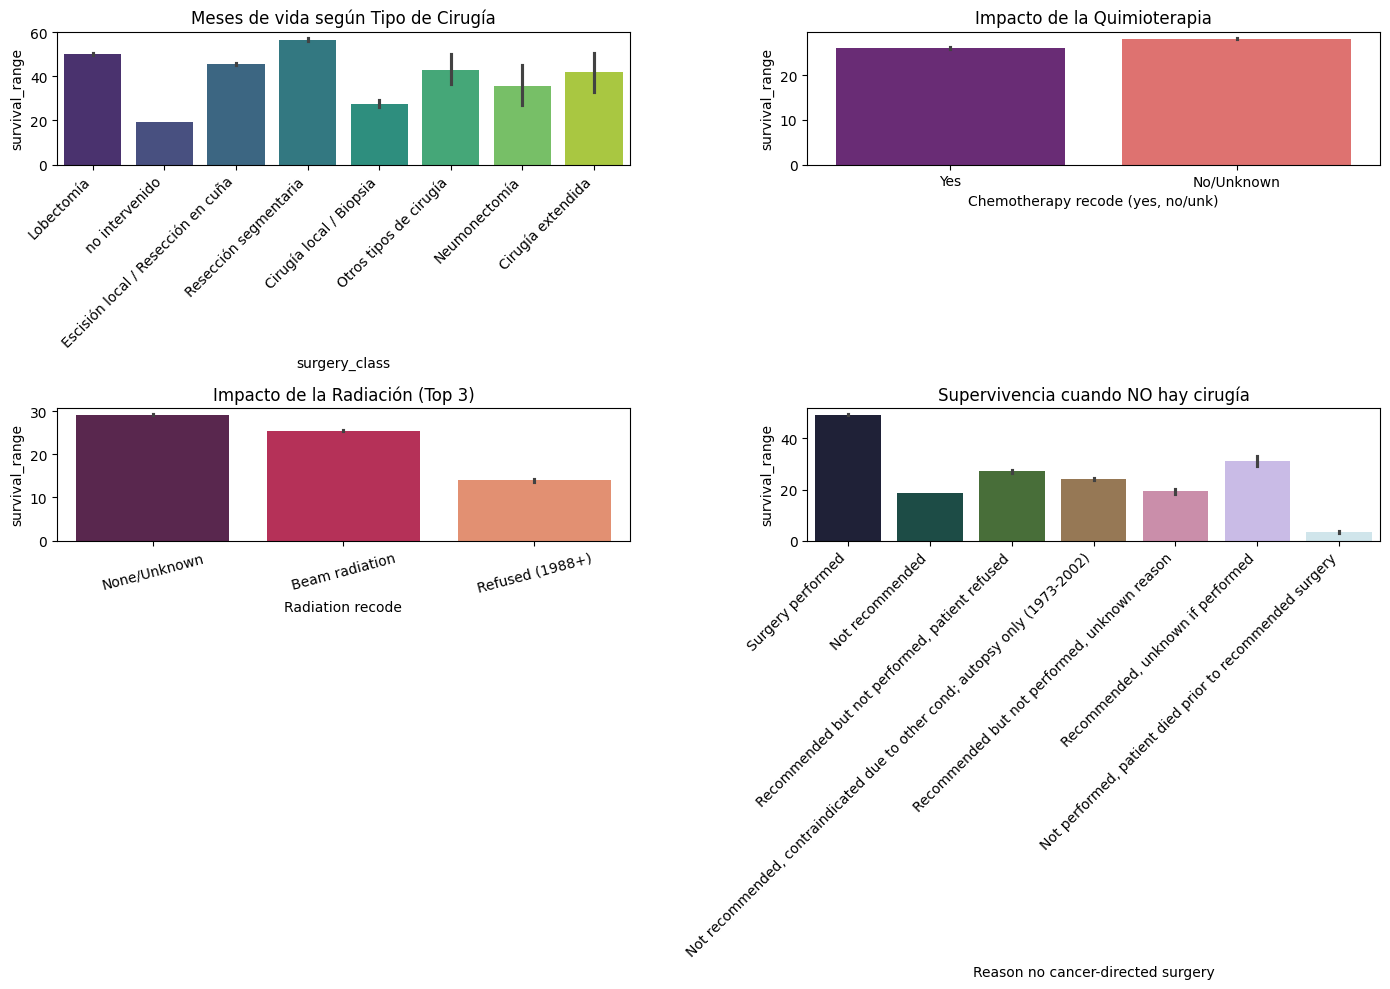

In [979]:


# Configuramos el estilo
plt.figure(figsize=(14, 10))

# 1. Gráfico de Supervivencia según el tipo de Cirugía (surgery_class)
plt.subplot(2, 2, 1)
sns.barplot(data=df, x='surgery_class', y='survival_range', palette='viridis')
plt.title('Meses de vida según Tipo de Cirugía')
plt.xticks(rotation=45, ha='right')

# 2. Gráfico según Quimioterapia (Chemo)
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Chemotherapy recode (yes, no/unk)', y='survival_range', palette='magma')
plt.title('Impacto de la Quimioterapia')

# 3. Gráfico según Radiación (simplificado para la gráfica)
plt.subplot(2, 2, 3)
# Filtramos solo los más comunes para no saturar
top_rad = df['Radiation recode'].value_counts().nlargest(3).index
sns.barplot(data=df[df['Radiation recode'].isin(top_rad)], x='Radiation recode', y='survival_range', palette='rocket')
plt.title('Impacto de la Radiación (Top 3)')
plt.xticks(rotation=15)

# 4. Gráfico según Razón de no cirugía
plt.subplot(2, 2, 4)
sns.barplot(data=df, x='Reason no cancer-directed surgery', y='survival_range', palette='cubehelix')
plt.title('Supervivencia cuando NO hay cirugía')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()